<center><h1>Proyecto Final</h1></center>
<center><h2>Elizabet Cano Mejía</h2></center>

Este cuaderno detalla el desarrollo de un modelo lineal generalizado que tiene como variable de respuesta la frecuencia de siniestros relacionados con daños de agua en conjuntos residenciales. Para abordar este problema, se utiliza una distribución de Poisson para modelar la frecuencia de los siniestros. El proceso abarca la carga de datos, el preprocesamiento de la información, la selección de variables pertinentes para el modelado y, finalmente, el desarrollo y ajuste del modelo.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import sys
import os
# Agregar la carpeta 'src' al sistema de rutas
sys.path.append(os.path.abspath('../src'))
# Ahora puedo importar el archivo o los módulos
from Proyecto_Funciones import *

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Lasso

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Tiempo de ejecución del código 
import time
start_time = time.time()

## 1. Carga de datos

In [2]:
dict_path=r'../src/data_dict.xlsx'
dic = pd.read_excel(dict_path)
dic

,Factores,NUMERICA,ORDINAL,CONTINUA,DISCRETA,LABEL,CATEGORÍA,MISSING,format
0,AGRUPAGENTE,1,0.00,0,1.00,Agrupacion del agente,03.Agente,True,FMT_AGRUPAGENTE
1,Altitud,1,1.00,0,1.00,Altitud (m),06.Geográfica,True,FMT_Altitud
2,antigedif,1,1.00,0,1.00,Antiguedad del edificio,04.Riesgo,True,FMT_antigedif
3,antigref,1,1.00,0,1.00,Antiguedad de la reforma,04.Riesgo,True,FMT_antigref
4,ANTIGUEDAD_VIVIENDA,1,1.00,0,1.00,Antiguedad de la vivienda (new),04.Riesgo,True,FMT_ANTIGUEDAD_VIVIENDA
...,...,...,...,...,...,...,...,...,...
676,zonas_hume,1,1.00,0,1.00,zonas_hume,08. Externas _2,True,FMT_zonas_hume
677,zonas_industriales_o_comerciales,1,1.00,0,1.00,zonas_industriales_o_comerciales,08. Externas _2,True,FMT_zonas_industriales_o_comerciales
678,zonas_portuarias,1,1.00,0,1.00,zonas_portuarias,08. Externas _2,True,FMT_zonas_portuarias
679,zonas_quemadas,1,1.00,0,1.00,zonas_quemadas,08. Externas _2,True,FMT_zonas_quemadas


In [3]:
df_path=r'../src/AGUA_V2_40.parquet'
df=pd.read_parquet(df_path)
df

,AGRUPAGENTE,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,AnyoCons_edif,AnyoCons_edif_total,AUX,bloqueo,CANAL,catage_emp,catage_glob,catage_hog,catage_tur,CATTAG,cl_cobro,codigo_grp,CODINE,CODPOST,CODPROV,COMESP,CONFCOMELE,Contr_Agr_pct,Contr_Cons_pct,Contr_ConvIndefH_pct,Contr_ConvIndefm_pct,Contr_Ind_pct,Contr_IndefH_pct,Contr_IndefM_pct,Contr_Serv_pct,Contr_TempH_pct,Contr_Tempm_pct,Contr_tot_pct,Conv_AVG,CORINE_VARIETY,CUPD_CAP_Corr_aguaacagbc,CUPD_Exc_aguaacagbc,DC,densidad_cpost,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,DIAS_PREC_SUP_30MM,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,DIAS_VIENT_MED_30KMH,DIAS_VIENT_MED_40KMH,DIAS_VIENT_MED_50KMH,DIST_COAST,Duracion_per_calido,Duracion_per_seco,edadtom,Elevation_AVG,EMSU_RISK,EQ_AVG,EQ_RISK,ERA5_Daily_avg_u,Etiq_AGUAACAGBC,ETP_anual,EU_IMP_IBU_100m,EU_IMP_IBU_10m,EU_IMP_IMD_100m,EU_IMP_IMD_10m,EU_LC_L1,EU_LC_L2,EU_TOPO_ASP_D4,EU_TOPO_ASP_D8,EU_TOPO_CONV,EU_TOPO_DIST_COAST,EU_TOPO_ELE,EU_TOPO_HAND,EU_TOPO_SLO,EU_VEG_FTY_100m,EU_VEG_FTY_10m,EU_VEG_TCD_100m,EU_VEG_TCD_10m,exp_corr_ACAGBC,EXPOSICION,extension,Factor_R,FI_RISK,Flood_AVG,FLRF_RISK,FLSW_RISK,FP,GMSeguros_indice_med,HA_RISK,HABITANTES,Hail_AVG,IMP_GMIS,Imperv_AVG,Ind_Turc_Regadio,Ind_Turc_Secano,K_ACAGBC,Landslide_AVG,LC_100m,LC_10m,MediadorLMI,mediaEdad,NIF_TIPO,NP_RB,nse,num_declaraciones,num_habitantes,p_africa,p_agpA,p_agpB,p_ALEM,p_americana,p_arabian,P_ARABIAN_VS_TOT,p_consF,p_cpers,p_dpers,p_east_EUR,P_EAST_EUR_VS_TOT,p_espa,p_extra,P_EXTRA_RESTO,p_induC,p_induD,p_induE,p_mcpers,p_p0004,p_p0019,p_p0509,p_p100M,p_p1014,p_p1519,p_p2024,p_p2039,p_p2529,p_p3034,p_p3539,p_p4044,p_p4064,p_p4549,p_p5054,p_p5559,p_p6064,p_p6569,p_p65M,p_p7074,p_p7579,p_p8084,p_p8589,p_p9094,p_p9599,p_portales_A,p_portales_B,p_portales_C,p_portales_D,p_portales_E,p_portales_F,p_portales_NA,p_servG,p_servH,p_servI,p_servJ,p_servK,p_servL,p_servM,p_servN,p_servO,p_servP,p_servQ,P_SUDAMER_VS_TOT,p_tpers,p_UE27,p_upers,p_WEST_EUR,P_WEST_EUR_VS_TOT,PACRAS,Paro_0024_pct,Paro_2544_pct,Paro_Agr_pct,Paro_Cons_pct,Paro_Dese_pct,Paro_Ind_pct,Paro_tot_pct,PCT_CLIENTE_AP,PCT_DTO_COMERCIAL,PCT_DTO_COMISION_AGENTE,PCT_DTO_TRASPASO,pct1524Tot,pct2544Tot,pctActTot,pctJovenTot,pctJubiladoTot,pctM45Tot,Pluviometria_anual,pob_1524Tot,pob_2544Tot,pob_actTot,pob_JovenTot,pob_JubiladoTot,pob_M45Tot,pob_Total,POL_ACCIDENTES,POL_AHORRO,POL_AUTOS,POL_COL_AHORRO,POL_COL_PENSIONES,POL_COL_RIESGO,POL_COMERCIO,POL_COMUNIDADES,POL_EMPRESAS,POL_FLOTAS,POL_HOGAR,POL_IND_AHORRO,POL_IND_FINANCIERO,POL_IND_PENSIONES,POL_IND_RIESGO,POL_MOTOS,POL_NO_VIDA,POL_NOAUTOS,POL_PATRIMONIALES,POL_PENSIONES,POL_RIESGO,POL_SALUD,POL_TOTAL,POL_TURISMOS,POL_VEH_COMERCIAL,POL_VIDA,POLAGE_ACCIDENTES,POLAGE_AUTOS,POLAGE_COMERCIO,POLAGE_COMUNIDADES,POLAGE_FLOTAS,POLAGE_HOGAR,POLAGE_MOTOS,POLAGE_NO_VIDA,POLAGE_NOAUTOS,POLAGE_TURISMOS,POLAGE_VEH_COMERCIAL,POP_GHS2015,POP_GPW2020,Population_AVG,PREC_E_OBS_100Y,PREC_E_OBS_10Y,PREC_E_OBS_25Y,PREC_E_OBS_50Y,PREC_E_OBS_5Y,PREC_ECAD_100Y,PREC_ECAD_10Y,PREC_ECAD_25Y,PREC_ECAD_50Y,PREC_ECAD_5Y,PREC_ERA5_100Y,PREC_ERA5_10Y,PREC_ERA5_25Y,PREC_ERA5_50Y,PREC_ERA5_5Y,PROPIETARIO,RAMO,ratDecl_Conjuntas,ratDecl_xHab,ratTitulares_xHab,renta_bruta,renta_bruta_media,renta_disponible,ROBINSON,SC_RISK,Slope_AVG,stro_1a_AGUAACAGBC,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,stro_4a_AGUAACAGBC,stro_5a_AGUAACAGBC,stro_Corr_AGUAACAGBC,Stro_G_aguaacagbc,SUPERFICIE,TAG,TC_RISK,TEMP_MAX_10Y,TEMP_MAX_30Y,TEMP_MAX_50Y,TEMP_MIN_10Y,TEMP_MIN_30Y,TEMP_MIN_50Y,Temperatura_med_anual,Temperatura_med_max_mes_calido,Temperatura_med_min_mes_frio,tipoImpositivoMedio,titulares,Tornado_AVG,tot_pob,Tree_cover_AVG,VEG_TCD,VIGILANCIA,Wind_AVG,WIND_GUST_10Y,WIND_GUST_30Y,WIND_GUST_50Y,WIND_MAX_10Y,WIND_MAX_30Y,WIND_MAX_50Y,WIND_MEAN_10Y,WIND_MEAN_30Y,WIND_MEAN_50Y,WS_RISK,year,aeropuertos,agricultural_mainland,agua,altura_mea,altura_std,arrozales,Arsenico_invier,Arsenico_otono,Arsenico_primav,Arsenico_verano,Benzo_invier,Benzo_otono,Benz

## 2. Definición de variable respuesta

Para los modelos de frecuencia la variable respuesta será el ratio entre 'stro_Corr_AGUAACAGBC' y 'exp_corr_ACAGBC'. Para esto, solo se trabajará con los datos que tienen 'exp_corr_ACAGBC' mayor que cero. 

In [4]:
df = df[df['exp_corr_ACAGBC']>0]
df['resp'] = df['stro_Corr_AGUAACAGBC']/df['exp_corr_ACAGBC']
df

,AGRUPAGENTE,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,AnyoCons_edif,AnyoCons_edif_total,AUX,bloqueo,CANAL,catage_emp,catage_glob,catage_hog,catage_tur,CATTAG,cl_cobro,codigo_grp,CODINE,CODPOST,CODPROV,COMESP,CONFCOMELE,Contr_Agr_pct,Contr_Cons_pct,Contr_ConvIndefH_pct,Contr_ConvIndefm_pct,Contr_Ind_pct,Contr_IndefH_pct,Contr_IndefM_pct,Contr_Serv_pct,Contr_TempH_pct,Contr_Tempm_pct,Contr_tot_pct,Conv_AVG,CORINE_VARIETY,CUPD_CAP_Corr_aguaacagbc,CUPD_Exc_aguaacagbc,DC,densidad_cpost,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,DIAS_PREC_SUP_30MM,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,DIAS_VIENT_MED_30KMH,DIAS_VIENT_MED_40KMH,DIAS_VIENT_MED_50KMH,DIST_COAST,Duracion_per_calido,Duracion_per_seco,edadtom,Elevation_AVG,EMSU_RISK,EQ_AVG,EQ_RISK,ERA5_Daily_avg_u,Etiq_AGUAACAGBC,ETP_anual,EU_IMP_IBU_100m,EU_IMP_IBU_10m,EU_IMP_IMD_100m,EU_IMP_IMD_10m,EU_LC_L1,EU_LC_L2,EU_TOPO_ASP_D4,EU_TOPO_ASP_D8,EU_TOPO_CONV,EU_TOPO_DIST_COAST,EU_TOPO_ELE,EU_TOPO_HAND,EU_TOPO_SLO,EU_VEG_FTY_100m,EU_VEG_FTY_10m,EU_VEG_TCD_100m,EU_VEG_TCD_10m,exp_corr_ACAGBC,EXPOSICION,extension,Factor_R,FI_RISK,Flood_AVG,FLRF_RISK,FLSW_RISK,FP,GMSeguros_indice_med,HA_RISK,HABITANTES,Hail_AVG,IMP_GMIS,Imperv_AVG,Ind_Turc_Regadio,Ind_Turc_Secano,K_ACAGBC,Landslide_AVG,LC_100m,LC_10m,MediadorLMI,mediaEdad,NIF_TIPO,NP_RB,nse,num_declaraciones,num_habitantes,p_africa,p_agpA,p_agpB,p_ALEM,p_americana,p_arabian,P_ARABIAN_VS_TOT,p_consF,p_cpers,p_dpers,p_east_EUR,P_EAST_EUR_VS_TOT,p_espa,p_extra,P_EXTRA_RESTO,p_induC,p_induD,p_induE,p_mcpers,p_p0004,p_p0019,p_p0509,p_p100M,p_p1014,p_p1519,p_p2024,p_p2039,p_p2529,p_p3034,p_p3539,p_p4044,p_p4064,p_p4549,p_p5054,p_p5559,p_p6064,p_p6569,p_p65M,p_p7074,p_p7579,p_p8084,p_p8589,p_p9094,p_p9599,p_portales_A,p_portales_B,p_portales_C,p_portales_D,p_portales_E,p_portales_F,p_portales_NA,p_servG,p_servH,p_servI,p_servJ,p_servK,p_servL,p_servM,p_servN,p_servO,p_servP,p_servQ,P_SUDAMER_VS_TOT,p_tpers,p_UE27,p_upers,p_WEST_EUR,P_WEST_EUR_VS_TOT,PACRAS,Paro_0024_pct,Paro_2544_pct,Paro_Agr_pct,Paro_Cons_pct,Paro_Dese_pct,Paro_Ind_pct,Paro_tot_pct,PCT_CLIENTE_AP,PCT_DTO_COMERCIAL,PCT_DTO_COMISION_AGENTE,PCT_DTO_TRASPASO,pct1524Tot,pct2544Tot,pctActTot,pctJovenTot,pctJubiladoTot,pctM45Tot,Pluviometria_anual,pob_1524Tot,pob_2544Tot,pob_actTot,pob_JovenTot,pob_JubiladoTot,pob_M45Tot,pob_Total,POL_ACCIDENTES,POL_AHORRO,POL_AUTOS,POL_COL_AHORRO,POL_COL_PENSIONES,POL_COL_RIESGO,POL_COMERCIO,POL_COMUNIDADES,POL_EMPRESAS,POL_FLOTAS,POL_HOGAR,POL_IND_AHORRO,POL_IND_FINANCIERO,POL_IND_PENSIONES,POL_IND_RIESGO,POL_MOTOS,POL_NO_VIDA,POL_NOAUTOS,POL_PATRIMONIALES,POL_PENSIONES,POL_RIESGO,POL_SALUD,POL_TOTAL,POL_TURISMOS,POL_VEH_COMERCIAL,POL_VIDA,POLAGE_ACCIDENTES,POLAGE_AUTOS,POLAGE_COMERCIO,POLAGE_COMUNIDADES,POLAGE_FLOTAS,POLAGE_HOGAR,POLAGE_MOTOS,POLAGE_NO_VIDA,POLAGE_NOAUTOS,POLAGE_TURISMOS,POLAGE_VEH_COMERCIAL,POP_GHS2015,POP_GPW2020,Population_AVG,PREC_E_OBS_100Y,PREC_E_OBS_10Y,PREC_E_OBS_25Y,PREC_E_OBS_50Y,PREC_E_OBS_5Y,PREC_ECAD_100Y,PREC_ECAD_10Y,PREC_ECAD_25Y,PREC_ECAD_50Y,PREC_ECAD_5Y,PREC_ERA5_100Y,PREC_ERA5_10Y,PREC_ERA5_25Y,PREC_ERA5_50Y,PREC_ERA5_5Y,PROPIETARIO,RAMO,ratDecl_Conjuntas,ratDecl_xHab,ratTitulares_xHab,renta_bruta,renta_bruta_media,renta_disponible,ROBINSON,SC_RISK,Slope_AVG,stro_1a_AGUAACAGBC,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,stro_4a_AGUAACAGBC,stro_5a_AGUAACAGBC,stro_Corr_AGUAACAGBC,Stro_G_aguaacagbc,SUPERFICIE,TAG,TC_RISK,TEMP_MAX_10Y,TEMP_MAX_30Y,TEMP_MAX_50Y,TEMP_MIN_10Y,TEMP_MIN_30Y,TEMP_MIN_50Y,Temperatura_med_anual,Temperatura_med_max_mes_calido,Temperatura_med_min_mes_frio,tipoImpositivoMedio,titulares,Tornado_AVG,tot_pob,Tree_cover_AVG,VEG_TCD,VIGILANCIA,Wind_AVG,WIND_GUST_10Y,WIND_GUST_30Y,WIND_GUST_50Y,WIND_MAX_10Y,WIND_MAX_30Y,WIND_MAX_50Y,WIND_MEAN_10Y,WIND_MEAN_30Y,WIND_MEAN_50Y,WS_RISK,year,aeropuertos,agricultural_mainland,agua,altura_mea,altura_std,arrozales,Arsenico_invier,Arsenico_otono,Arsenico_primav,Arsenico_verano,Benzo_invier,Benzo_otono,Benz

## 3. Selección manual de variables 

La selección de variables manual para este modelo se realiza partiendo de un análisis conceptual de las características que podrían influir en la frecuencia de siniestros relacionados con daños por agua en conjuntos residenciales. En esta etapa, se utilizan criterios teóricos y un diccionario de datos para identificar variables clave que podrían tener un impacto significativo en el riesgo de siniestros. Las variables más relevantes están relacionadas con características de la propiedad, la infraestructura, las condiciones climáticas, los hábitos de uso del inmueble y aspectos históricos de siniestros.

**Variables seleccionadas manualmente utilizando criterio conceptual:**

1. **Altitud**: La altitud de un lugar puede influir en el clima y en la cantidad de precipitaciones, lo que podría afectar la frecuencia y severidad de los daños por agua en las viviendas.

2. **antigedif** (Antigüedad del edificio): La antigüedad de un edificio es crucial porque los edificios más antiguos podrían tener infraestructuras de fontanería y aislamiento menos eficientes, aumentando el riesgo de daños por agua.

3. **antigref** (Antigüedad de la reforma): Esta variable permite conocer si un edificio ha sido renovado y cuándo, ya que las reformas pueden actualizar la infraestructura y reducir el riesgo de siniestros.

4. **ANTIGUEDAD_VIVIENDA** Similar a la antigüedad del edificio, la antigüedad de la vivienda puede reflejar la calidad de sus materiales y la posible necesidad de mantenimiento para evitar daños por agua.

5. **anualidad_reemplazo** (Anualidad del reemplazo): Este indicador refleja la frecuencia de reemplazo de materiales o componentes del edificio, lo cual es relevante para evaluar el riesgo de daños.

6. **anualidad_seguro** (Anualidad del Seguro): Puede indicar la cantidad de cobertura que tiene una vivienda o un edificio, lo cual podría correlacionarse con la probabilidad de siniestros reportados.

7. **CODPROV** (Provincia): La ubicación geográfica puede influir en los patrones climáticos y en la frecuencia de eventos climáticos que provocan daños por agua.

8. **CUPD_CAP_Corr_aguaacagbc** (Costo actualizado de reparación de daños de agua): Este dato es fundamental para evaluar la magnitud de los siniestros, ya que indica el costo de los daños y su impacto económico.

9. **CUPD_Exc_aguaacagbc** (Costo actualizado de daños extraordinarios de agua): Permite identificar los costos de daños inusuales, lo que es importante para prever la severidad de los siniestros.

10. **DIAS_PREC_SUP_10MM** (Días con precipitaciones mayores a 10MM): La cantidad de días con precipitaciones intensas puede ayudar a modelar el riesgo de siniestros, ya que lluvias fuertes aumentan la probabilidad de daños por agua.

11. **DIAS_PREC_SUP_1MM** (Días con precipitaciones mayores a 1MM): Similar a la variable anterior, pero para precipitaciones de menor intensidad que aún podrían tener un impacto en el riesgo de daños.

12. **DIAS_PREC_SUP_30MM** (Días con precipitaciones mayores a 30MM): Esta variable captura eventos de lluvias muy intensas que podrían llevar a inundaciones y daños importantes en los edificios.

13. **DIAS_VIENT_MAX_60KMH** (Días con vientos de máxima 60 km/h): Aunque no es directamente relacionado con el agua, los vientos fuertes pueden contribuir a daños en la infraestructura que, a su vez, aumenten la vulnerabilidad a problemas de agua.

14. **DIAS_VIENT_MAX_70KMH** (Días con vientos de máxima 70 km/h): Similar a la variable anterior, puede indicar el riesgo de daños estructurales que faciliten filtraciones de agua.

15. **DIAS_VIENT_MAX_80KMH** (Días con vientos de máxima 80 km/h): Vientos más fuertes pueden dañar el techado y otras estructuras, aumentando el riesgo de siniestros por agua.

16. **DIAS_VIENT_MED_30KMH** (Días con vientos de media 30 km/h): La velocidad media del viento puede influir en la frecuencia de daños y, por ende, en la exposición a riesgos de agua.

17. **DIAS_VIENT_MED_40KMH** (Días con vientos de media 40 km/h): Proporciona información adicional sobre la exposición al viento y sus efectos potenciales en la infraestructura.

18. **DIAS_VIENT_MED_50KMH** (Días con vientos de media 50 km/h): Las condiciones de viento fuertes pueden ser factores contribuyentes al daño por agua al afectar el techo y otras áreas críticas.

19. **Duracion_per_calido** (Duración del período cálido): Las temperaturas cálidas pueden influir en la acumulación de humedad y en la exposición a riesgos como filtraciones y roturas de tuberías.

20. **Duracion_per_seco** (Duración del período seco): Los períodos secos prolongados pueden afectar la integridad de las tuberías y otras estructuras, aumentando el riesgo de daños por agua en eventos subsecuentes.

21. **edadtom** (Edad del tomador): La edad del tomador puede ser un factor de riesgo, ya que personas de mayor edad podrían tener menos capacidad para realizar mantenimientos preventivos.

22. **Elevation_AVG** (Altitud promedio): La elevación promedio puede correlacionarse con la cantidad de precipitación y el riesgo de inundaciones.

23. **EQ_AVG** (Riesgo promedio de zona de terremotos): Los terremotos pueden provocar daños estructurales que faciliten filtraciones y daños por agua.

24. **Etiq_AGUAACAGBC** (Etiqueta de riesgos de agua): Refleja la categorización o clasificación de riesgo de agua, una variable importante para evaluar la probabilidad de siniestros.

25. **HABITANTES** (Número de habitantes): La densidad de habitantes puede influir en la demanda de servicios y la frecuencia de problemas relacionados con el agua.

26. **K_ACAGBC** (Coeficiente de riesgo de agua): Esta variable podría ser un índice o coeficiente que permita evaluar el riesgo de siniestros por agua de manera cuantitativa.

27. **NIF_TIPO** (Tipos de NIF): Puede relacionarse con la identificación de la persona y sus características socioeconómicas, lo que podría influir en el mantenimiento y la prevención de daños.

28. **nse** (Nivel socioeconómico del CP): El nivel socioeconómico puede influir en la capacidad de mantenimiento de los edificios y en la predisposición a reportar siniestros.

29. **num_habitantes** (Número de habitantes): Reiteración de la densidad de población, importante para evaluar la exposición de las propiedades al riesgo de daños.

30. **POL_HOGAR** (Número de pólizas del cliente - Hogar): Indica cuántas pólizas de seguro tiene el cliente en su hogar, lo cual puede correlacionarse con la frecuencia de siniestros.

31. **POL_NO_VIDA** (Pólizas de seguro no vida): Similar a la variable anterior, relacionada con la frecuencia de incidencias en la vivienda.

32. **POL_PATRIMONIALES** (Pólizas patrimoniales): Incluye seguro que podría cubrir daños estructurales y de propiedad, indicando potenciales siniestros pasados.

33. **POL_PENSIONES** (Pólizas de pensiones): Aunque menos directa, puede indicar una mayor edad y menos movilidad para la gestión de riesgos.

34. **POL_RIESGO** (Pólizas de riesgo): Relacionada con la protección ante daños, importante para saber la cobertura frente a siniestros de agua.

35. **POL_TOTAL** (Número total de pólizas del cliente): Ayuda a comprender la exposición general del cliente y su predisposición a asegurar diferentes aspectos de su propiedad.

36. **renta_bruta** (Renta bruta): La capacidad económica del tomador de la póliza puede influir en la calidad del mantenimiento de la vivienda.

37. **renta_bruta_media** (Renta bruta media): Similar a la variable anterior, da un contexto del nivel económico en el área y su relación con la frecuencia de siniestros.

38. **stro_1a_AGUAACAGBC**: Representa la medición de daños o riesgos por agua en el primer año, lo cual es útil para modelar la frecuencia de siniestros y entender patrones históricos de daños.

39. **stro_2a_AGUAACAGBC**: Refleja la evaluación de daños en el segundo año, permitiendo identificar tendencias en la incidencia de daños y patrones de riesgo a lo largo del tiempo.

40. **stro_3a_AGUAACAGBC**: Relacionada con la evaluación en el tercer año, proporciona una visión a largo plazo sobre la tendencia de siniestros, esencial para modelar la probabilidad de futuros daños.

41. **stro_4a_AGUAACAGBC**: Medición en el cuarto año que ayuda a detectar concentraciones de daños en ciertos períodos y a entender el comportamiento de los siniestros a lo largo del tiempo.

42. **stro_5a_AGUAACAGBC**: Evaluación en el quinto año, útil para observar si existe un incremento en la frecuencia de daños a lo largo de los años y modelar la probabilidad de siniestros de manera precisa.

43. **Stro_G_aguaacagbc** (Historial general de daños por agua): Un índice que indica la frecuencia total de siniestros por daños de agua.

44. **SUPERFICIE**: La superficie construida influye en la magnitud de los daños por agua, ya que las viviendas más grandes pueden tener un mayor riesgo de siniestros debido a áreas amplias susceptibles a daños.

45. **Temperatura_med_anual**: Las zonas con temperaturas más altas pueden presentar un mayor riesgo de humedad y condensación, lo cual puede resultar en daños por agua a lo largo del tiempo.

46. **Temperatura_med_max_mes_calido**: Los picos de calor en la región pueden afectar la evaporación y la acumulación de humedad, lo que influye en la posibilidad de daños como el deterioro de techos y canalizaciones.

47. **Temperatura_med_min_mes_frio**: Las temperaturas mínimas en el mes más frío ayudan a evaluar el riesgo de congelación en las tuberías, lo que podría provocar rupturas y daños por agua por congelación y descongelación.

48. **Tornado_AVG**: Las zonas propensas a tornados tienen un mayor riesgo de daños severos en la infraestructura, lo que puede causar filtraciones de agua y daños a largo plazo en los edificios.

49. **tot_pob**: La densidad poblacional puede indicar el nivel de exposición al riesgo de siniestros, ya que zonas con más habitantes pueden tener una infraestructura más afectada y una mayor demanda de servicios de reparación de daños por agua.

50. **year**: El año de renovación es importante porque las viviendas renovadas tienen una infraestructura más moderna y resistente, reduciendo el riesgo de daños, mientras que las no renovadas pueden tener un mayor riesgo debido a materiales y sistemas de construcción más antiguos.

In [5]:
# Lista de variables 
variables_a_filtrar = [
    'Altitud',
    'antigedif',
    'antigref',
    'ANTIGUEDAD_VIVIENDA',
    'anualidad_reemplazo',
    'anualidad_seguro',
    'CODPROV',
    'CUPD_CAP_Corr_aguaacagbc',
    'CUPD_Exc_aguaacagbc',
    'DIAS_PREC_SUP_10MM',
    'DIAS_PREC_SUP_1MM',
    'DIAS_PREC_SUP_30MM',
    'DIAS_VIENT_MAX_60KMH',
    'DIAS_VIENT_MAX_70KMH',
    'DIAS_VIENT_MAX_80KMH',
    'DIAS_VIENT_MED_30KMH',
    'DIAS_VIENT_MED_40KMH',
    'DIAS_VIENT_MED_50KMH',
    'Duracion_per_calido',
    'Duracion_per_seco',
    'edadtom',
    'Elevation_AVG',
    'EQ_AVG',
    'Etiq_AGUAACAGBC',
    'HABITANTES',
    'K_ACAGBC',
    'NIF_TIPO',
    'nse',
    'num_habitantes',
    'POL_HOGAR',
    'POL_NO_VIDA',
    'POL_PATRIMONIALES',
    'POL_PENSIONES',
    'POL_RIESGO',
    'POL_TOTAL',
    'renta_bruta',
    'renta_bruta_media',
    'stro_1a_AGUAACAGBC',
    'stro_2a_AGUAACAGBC',
    'stro_3a_AGUAACAGBC',
    'stro_4a_AGUAACAGBC',
    'stro_5a_AGUAACAGBC',
    'Stro_G_aguaacagbc',
    'SUPERFICIE',
    'Temperatura_med_anual',
    'Temperatura_med_max_mes_calido',
    'Temperatura_med_min_mes_frio',
    'Tornado_AVG',
    'tot_pob',
    'year', 
    'resp',
    'stro_Corr_AGUAACAGBC',
    'exp_corr_ACAGBC'
]

# Filtrar el DataFrame df con las variables seleccionadas
df_filtrado = df[variables_a_filtrar]
df_filtrado

,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,CODPROV,CUPD_CAP_Corr_aguaacagbc,CUPD_Exc_aguaacagbc,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,DIAS_PREC_SUP_30MM,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,DIAS_VIENT_MED_30KMH,DIAS_VIENT_MED_40KMH,DIAS_VIENT_MED_50KMH,Duracion_per_calido,Duracion_per_seco,edadtom,Elevation_AVG,EQ_AVG,Etiq_AGUAACAGBC,HABITANTES,K_ACAGBC,NIF_TIPO,nse,num_habitantes,POL_HOGAR,POL_NO_VIDA,POL_PATRIMONIALES,POL_PENSIONES,POL_RIESGO,POL_TOTAL,renta_bruta,renta_bruta_media,stro_1a_AGUAACAGBC,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,stro_4a_AGUAACAGBC,stro_5a_AGUAACAGBC,Stro_G_aguaacagbc,SUPERFICIE,Temperatura_med_anual,Temperatura_med_max_mes_calido,Temperatura_med_min_mes_frio,Tornado_AVG,tot_pob,year,resp,stro_Corr_AGUAACAGBC,exp_corr_ACAGBC
2,52.00,12.00,NaN,12.00,99.00,2.00,3.00,0.00,0.00,13.80,48.00,3.00,21.00,7.00,2.70,0.70,0.00,0.00,2.00,5.96,NaN,38.13,2.00,Valores coherentes,13.00,50050.00,J,3.86,24367.00,0.00,1.00,1.00,0.00,0.00,1.00,320193342.00,13142.61,1.00,0.00,0.00,0.00,0.00,0,1020.00,17.70,31.70,5.90,1.00,24363.00,2021.00,0.00,0.00,0.67
3,868.00,42.00,NaN,42.00,99.00,8.00,24.00,48.23,0.00,19.00,103.00,1.00,19.00,8.00,2.00,1.00,0.00,0.00,0.00,2.70,NaN,838.62,1.00,Valores coherentes,135.00,41488.54,J,4.02,124028.00,0.00,1.00,1.00,0.00,0.00,1.00,2059830432.00,16607.79,1.00,1.00,2.00,3.00,4.00,0,2700.00,11.30,28.80,-1.30,1.00,5414.00,2020.00,3.00,1.00,0.33
4,24.00,58.00,NaN,58.00,99.00,2.00,12.00,0.00,0.00,0.00,0.00,0.00,14.00,5.70,2.00,3.00,0.00,0.00,1.00,3.48,NaN,9.63,1.00,Valores coherentes,25.00,70070.00,J,3.86,35052.00,0.00,1.00,1.00,0.00,0.00,1.00,396494280.00,11359.89,0.00,0.00,0.00,0.00,0.00,0,658.00,16.50,29.50,4.70,2.00,34903.00,2021.00,0.00,0.00,0.83
5,95.00,26.00,NaN,26.00,99.00,3.00,8.00,0.00,0.00,24.80,69.00,6.80,11.70,3.00,1.00,0.00,0.00,0.00,1.00,2.80,NaN,70.78,2.07,Valores coherentes,20.00,34402.56,J,3.88,28268.00,0.00,1.00,1.00,0.00,0.00,1.00,368011160.00,13106.28,3.00,3.00,0.00,0.00,0.00,0,711.00,15.40,29.80,3.70,2.00,28115.00,2022.00,0.00,0.00,0.67
6,544.00,23.00,NaN,23.00,1.00,6.00,23.00,0.00,0.00,26.40,77.00,3.00,19.00,9.70,3.00,0.00,0.00,0.00,2.00,4.33,82.00,534.26,1.15,Valores coherentes,103.00,31878.00,N,3.40,225514.00,1.00,2.00,2.00,0.00,0.00,2.00,3097974096.00,13871.24,0.00,0.00,0.00,0.00,0.00,0,500.00,16.60,35.20,2.80,1.00,7898.00,2023.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371384,158.00,23.00,NaN,23.00,99.00,9.00,48.00,0.00,0.00,44.00,150.00,5.80,31.70,13.00,5.70,3.00,0.00,0.00,0.00,0.92,NaN,34.52,1.00,Valores coherentes,382.00,74087.98,J,4.89,1032381.00,0.00,1.00,1.00,0.00,0.00,1.00,15206163465.00,14729.22,1.00,2.00,2.00,2.00,2.00,0,1980.00,13.40,24.60,4.30,1.00,13672.00,2023.00,0.00,0.00,0.50
371385,129.00,65.00,11.00,11.00,99.00,4.00,8.00,0.00,0.00,26.80,70.80,6.80,8.70,3.00,1.00,2.00,0.00,0.00,0.00,3.07,NaN,31.03,2.00,Valores coherentes,100.00,30720.69,J,3.80,129661.00,0.00,1.00,1.00,0.00,0.00,1.00,1572529952.00,12194.31,0.00,1.00,0.00,0.00,0.00,0,480.00,15.90,29.00,5.10,2.00,22341.00,2022.00,0.00,0.00,0.67
371386,132.00,53.00,NaN,53.00,99.00,2.00,46.00,201.44,0.00,17.00,53.00,2.00,11.00,3.70,1.00,2.00,0.00,0.00,1.00,2.84,NaN,94.13,2.40,Valores coherentes,0.00,37906.94,J,3.39,17254.00,0.00,1.00,1.00,0.00,0.00,1.00,198781341.00,11542.29,3.00,0.00,0.00,0.00,0.00,0,936.00,16.60,29.90,5.70,1.00,17162.00,2023.00,1.94,1.00,0.52
371387,93.00,18.00,NaN,18.00,99.00,3.00,12.00,2500.00,6920.08,0.00,0.00,0.00,14.00,5.70,2.00,3.00,0.00,0.00,0.00,3.46,NaN,89.65,1.00,Valores coherentes,0.00,508039.59,J,3.63,9339.00,0.00,1.00,1.00,0.00,0.00,1.00,104596002.00,10270.62,3.00,8.00,0.00,0.00,0.00,1,31137.00,16.10,30.80,4.20,2.00,9755.00,2022.00,3.51,1.00,0.28


## 4. Preprocesamiento y limpieza de datos

### 4.1. Tratamiento de variables categóricas - dummies

In [6]:
# Year se debe tratar como variable categórica 
df_filtrado['year'] = df_filtrado['year'].astype('object')

In [7]:
# Identificar columnas categóricas
categorical_cols = df_filtrado.select_dtypes(include=['object', 'category']).columns
print("Columnas categóricas:", categorical_cols)

Columnas categóricas: Index(['Etiq_AGUAACAGBC', 'NIF_TIPO', 'year'], dtype='object')


In [8]:
# Convertir a dummies
df_dummies = pd.get_dummies(df_filtrado, columns=categorical_cols, drop_first=True)  # drop_first evita la multicolinealidad
df_dummies

,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,CODPROV,CUPD_CAP_Corr_aguaacagbc,CUPD_Exc_aguaacagbc,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,DIAS_PREC_SUP_30MM,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,DIAS_VIENT_MED_30KMH,DIAS_VIENT_MED_40KMH,DIAS_VIENT_MED_50KMH,Duracion_per_calido,Duracion_per_seco,edadtom,Elevation_AVG,EQ_AVG,HABITANTES,K_ACAGBC,nse,num_habitantes,POL_HOGAR,POL_NO_VIDA,POL_PATRIMONIALES,POL_PENSIONES,POL_RIESGO,POL_TOTAL,renta_bruta,renta_bruta_media,stro_1a_AGUAACAGBC,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,stro_4a_AGUAACAGBC,stro_5a_AGUAACAGBC,Stro_G_aguaacagbc,SUPERFICIE,Temperatura_med_anual,Temperatura_med_max_mes_calido,Temperatura_med_min_mes_frio,Tornado_AVG,tot_pob,resp,stro_Corr_AGUAACAGBC,exp_corr_ACAGBC,Etiq_AGUAACAGBC_Valores coherentes - 500.0,NIF_TIPO_J,NIF_TIPO_N,year_2021.0,year_2022.0,year_2023.0
2,52.00,12.00,NaN,12.00,99.00,2.00,3.00,0.00,0.00,13.80,48.00,3.00,21.00,7.00,2.70,0.70,0.00,0.00,2.00,5.96,NaN,38.13,2.00,13.00,50050.00,3.86,24367.00,0.00,1.00,1.00,0.00,0.00,1.00,320193342.00,13142.61,1.00,0.00,0.00,0.00,0.00,0,1020.00,17.70,31.70,5.90,1.00,24363.00,0.00,0.00,0.67,0,1,0,1,0,0
3,868.00,42.00,NaN,42.00,99.00,8.00,24.00,48.23,0.00,19.00,103.00,1.00,19.00,8.00,2.00,1.00,0.00,0.00,0.00,2.70,NaN,838.62,1.00,135.00,41488.54,4.02,124028.00,0.00,1.00,1.00,0.00,0.00,1.00,2059830432.00,16607.79,1.00,1.00,2.00,3.00,4.00,0,2700.00,11.30,28.80,-1.30,1.00,5414.00,3.00,1.00,0.33,0,1,0,0,0,0
4,24.00,58.00,NaN,58.00,99.00,2.00,12.00,0.00,0.00,0.00,0.00,0.00,14.00,5.70,2.00,3.00,0.00,0.00,1.00,3.48,NaN,9.63,1.00,25.00,70070.00,3.86,35052.00,0.00,1.00,1.00,0.00,0.00,1.00,396494280.00,11359.89,0.00,0.00,0.00,0.00,0.00,0,658.00,16.50,29.50,4.70,2.00,34903.00,0.00,0.00,0.83,0,1,0,1,0,0
5,95.00,26.00,NaN,26.00,99.00,3.00,8.00,0.00,0.00,24.80,69.00,6.80,11.70,3.00,1.00,0.00,0.00,0.00,1.00,2.80,NaN,70.78,2.07,20.00,34402.56,3.88,28268.00,0.00,1.00,1.00,0.00,0.00,1.00,368011160.00,13106.28,3.00,3.00,0.00,0.00,0.00,0,711.00,15.40,29.80,3.70,2.00,28115.00,0.00,0.00,0.67,0,1,0,0,1,0
6,544.00,23.00,NaN,23.00,1.00,6.00,23.00,0.00,0.00,26.40,77.00,3.00,19.00,9.70,3.00,0.00,0.00,0.00,2.00,4.33,82.00,534.26,1.15,103.00,31878.00,3.40,225514.00,1.00,2.00,2.00,0.00,0.00,2.00,3097974096.00,13871.24,0.00,0.00,0.00,0.00,0.00,0,500.00,16.60,35.20,2.80,1.00,7898.00,0.00,0.00,1.00,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371384,158.00,23.00,NaN,23.00,99.00,9.00,48.00,0.00,0.00,44.00,150.00,5.80,31.70,13.00,5.70,3.00,0.00,0.00,0.00,0.92,NaN,34.52,1.00,382.00,74087.98,4.89,1032381.00,0.00,1.00,1.00,0.00,0.00,1.00,15206163465.00,14729.22,1.00,2.00,2.00,2.00,2.00,0,1980.00,13.40,24.60,4.30,1.00,13672.00,0.00,0.00,0.50,0,1,0,0,0,1
371385,129.00,65.00,11.00,11.00,99.00,4.00,8.00,0.00,0.00,26.80,70.80,6.80,8.70,3.00,1.00,2.00,0.00,0.00,0.00,3.07,NaN,31.03,2.00,100.00,30720.69,3.80,129661.00,0.00,1.00,1.00,0.00,0.00,1.00,1572529952.00,12194.31,0.00,1.00,0.00,0.00,0.00,0,480.00,15.90,29.00,5.10,2.00,22341.00,0.00,0.00,0.67,0,1,0,0,1,0
371386,132.00,53.00,NaN,53.00,99.00,2.00,46.00,201.44,0.00,17.00,53.00,2.00,11.00,3.70,1.00,2.00,0.00,0.00,1.00,2.84,NaN,94.13,2.40,0.00,37906.94,3.39,17254.00,0.00,1.00,1.00,0.00,0.00,1.00,198781341.00,11542.29,3.00,0.00,0.00,0.00,0.00,0,936.00,16.60,29.90,5.70,1.00,17162.00,1.94,1.00,0.52,0,1,0,0,0,1
371387,93.00,18.00,NaN,18.00,99.00,3.00,12.00,2500.00,6920.08,0.00,0.00,0.00,14.00,5.70,2.00,3.00,0.00,0.00,0.00,3.46,NaN,89.65,1.00,0.00,508039.59,3.63,9339.00,0.00,1.00,1.00,0.00,0.00,1.00,104596002.00,10270.62,3.00,8.00,0.00,0.00,0.00,1,31137.00,16.10,30.80,4.20,2.00,9755.00,3.51,1.00,0.28,0,1,0,0,1,0


### 4.2. Tratamiento de datos nulos y valores -999

In [9]:
# Calcular proporción de nulos por columna
missing_values = df_dummies.isnull().mean()
missing_values

Altitud                                      0.01
antigedif                                    0.00
antigref                                     0.84
ANTIGUEDAD_VIVIENDA                          0.00
anualidad_reemplazo                          0.00
anualidad_seguro                             0.00
CODPROV                                      0.00
CUPD_CAP_Corr_aguaacagbc                     0.00
CUPD_Exc_aguaacagbc                          0.00
DIAS_PREC_SUP_10MM                           0.00
DIAS_PREC_SUP_1MM                            0.00
DIAS_PREC_SUP_30MM                           0.00
DIAS_VIENT_MAX_60KMH                         0.00
DIAS_VIENT_MAX_70KMH                         0.00
DIAS_VIENT_MAX_80KMH                         0.00
DIAS_VIENT_MED_30KMH                         0.00
DIAS_VIENT_MED_40KMH                         0.00
DIAS_VIENT_MED_50KMH                         0.00
Duracion_per_calido                          0.01
Duracion_per_seco                            0.01


In [10]:
# Filtrar columnas con más del 80% de datos nulos
columnas = missing_values[missing_values > 0.8].index
df_dummies = df_dummies.drop(columns=columnas)

# Mostrar las columnas que tienen más del 80% de datos nulos
print("Columnas con más del 80% de datos nulos que serán eliminadas:")
print(columnas)

Columnas con más del 80% de datos nulos que serán eliminadas:
Index(['antigref', 'edadtom'], dtype='object')


In [11]:
# Reemplazar los valores nulos de las demás variables con la mediana de cada columna
df_final = df_dummies.apply(lambda col: col.fillna(col.median()))
df_final

,Altitud,antigedif,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,CODPROV,CUPD_CAP_Corr_aguaacagbc,CUPD_Exc_aguaacagbc,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,DIAS_PREC_SUP_30MM,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,DIAS_VIENT_MED_30KMH,DIAS_VIENT_MED_40KMH,DIAS_VIENT_MED_50KMH,Duracion_per_calido,Duracion_per_seco,Elevation_AVG,EQ_AVG,HABITANTES,K_ACAGBC,nse,num_habitantes,POL_HOGAR,POL_NO_VIDA,POL_PATRIMONIALES,POL_PENSIONES,POL_RIESGO,POL_TOTAL,renta_bruta,renta_bruta_media,stro_1a_AGUAACAGBC,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,stro_4a_AGUAACAGBC,stro_5a_AGUAACAGBC,Stro_G_aguaacagbc,SUPERFICIE,Temperatura_med_anual,Temperatura_med_max_mes_calido,Temperatura_med_min_mes_frio,Tornado_AVG,tot_pob,resp,stro_Corr_AGUAACAGBC,exp_corr_ACAGBC,Etiq_AGUAACAGBC_Valores coherentes - 500.0,NIF_TIPO_J,NIF_TIPO_N,year_2021.0,year_2022.0,year_2023.0
2,52.00,12.00,12.00,99.00,2.00,3.00,0.00,0.00,13.80,48.00,3.00,21.00,7.00,2.70,0.70,0.00,0.00,2.00,5.96,38.13,2.00,13.00,50050.00,3.86,24367.00,0.00,1.00,1.00,0.00,0.00,1.00,320193342.00,13142.61,1.00,0.00,0.00,0.00,0.00,0,1020.00,17.70,31.70,5.90,1.00,24363.00,0.00,0.00,0.67,0,1,0,1,0,0
3,868.00,42.00,42.00,99.00,8.00,24.00,48.23,0.00,19.00,103.00,1.00,19.00,8.00,2.00,1.00,0.00,0.00,0.00,2.70,838.62,1.00,135.00,41488.54,4.02,124028.00,0.00,1.00,1.00,0.00,0.00,1.00,2059830432.00,16607.79,1.00,1.00,2.00,3.00,4.00,0,2700.00,11.30,28.80,-1.30,1.00,5414.00,3.00,1.00,0.33,0,1,0,0,0,0
4,24.00,58.00,58.00,99.00,2.00,12.00,0.00,0.00,0.00,0.00,0.00,14.00,5.70,2.00,3.00,0.00,0.00,1.00,3.48,9.63,1.00,25.00,70070.00,3.86,35052.00,0.00,1.00,1.00,0.00,0.00,1.00,396494280.00,11359.89,0.00,0.00,0.00,0.00,0.00,0,658.00,16.50,29.50,4.70,2.00,34903.00,0.00,0.00,0.83,0,1,0,1,0,0
5,95.00,26.00,26.00,99.00,3.00,8.00,0.00,0.00,24.80,69.00,6.80,11.70,3.00,1.00,0.00,0.00,0.00,1.00,2.80,70.78,2.07,20.00,34402.56,3.88,28268.00,0.00,1.00,1.00,0.00,0.00,1.00,368011160.00,13106.28,3.00,3.00,0.00,0.00,0.00,0,711.00,15.40,29.80,3.70,2.00,28115.00,0.00,0.00,0.67,0,1,0,0,1,0
6,544.00,23.00,23.00,1.00,6.00,23.00,0.00,0.00,26.40,77.00,3.00,19.00,9.70,3.00,0.00,0.00,0.00,2.00,4.33,534.26,1.15,103.00,31878.00,3.40,225514.00,1.00,2.00,2.00,0.00,0.00,2.00,3097974096.00,13871.24,0.00,0.00,0.00,0.00,0.00,0,500.00,16.60,35.20,2.80,1.00,7898.00,0.00,0.00,1.00,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371384,158.00,23.00,23.00,99.00,9.00,48.00,0.00,0.00,44.00,150.00,5.80,31.70,13.00,5.70,3.00,0.00,0.00,0.00,0.92,34.52,1.00,382.00,74087.98,4.89,1032381.00,0.00,1.00,1.00,0.00,0.00,1.00,15206163465.00,14729.22,1.00,2.00,2.00,2.00,2.00,0,1980.00,13.40,24.60,4.30,1.00,13672.00,0.00,0.00,0.50,0,1,0,0,0,1
371385,129.00,65.00,11.00,99.00,4.00,8.00,0.00,0.00,26.80,70.80,6.80,8.70,3.00,1.00,2.00,0.00,0.00,0.00,3.07,31.03,2.00,100.00,30720.69,3.80,129661.00,0.00,1.00,1.00,0.00,0.00,1.00,1572529952.00,12194.31,0.00,1.00,0.00,0.00,0.00,0,480.00,15.90,29.00,5.10,2.00,22341.00,0.00,0.00,0.67,0,1,0,0,1,0
371386,132.00,53.00,53.00,99.00,2.00,46.00,201.44,0.00,17.00,53.00,2.00,11.00,3.70,1.00,2.00,0.00,0.00,1.00,2.84,94.13,2.40,0.00,37906.94,3.39,17254.00,0.00,1.00,1.00,0.00,0.00,1.00,198781341.00,11542.29,3.00,0.00,0.00,0.00,0.00,0,936.00,16.60,29.90,5.70,1.00,17162.00,1.94,1.00,0.52,0,1,0,0,0,1
371387,93.00,18.00,18.00,99.00,3.00,12.00,2500.00,6920.08,0.00,0.00,0.00,14.00,5.70,2.00,3.00,0.00,0.00,0.00,3.46,89.65,1.00,0.00,508039.59,3.63,9339.00,0.00,1.00,1.00,0.00,0.00,1.00,104596002.00,10270.62,3.00,8.00,0.00,0.00,0.00,1,31137.00,16.10,30.80,4.20,2.00,9755.00,3.51,1.00,0.28,0,1,0,0,1,0


In [12]:
# Reemplazar los valores -999 con la mediana de cada columna ya que se interpretan como nulos
columnas_a_reemplazar = ['POL_HOGAR', 'POL_TOTAL', 'stro_1a_AGUAACAGBC', 'stro_2a_AGUAACAGBC', 'stro_3a_AGUAACAGBC', 
                        'stro_4a_AGUAACAGBC', 'stro_5a_AGUAACAGBC',]

for col in columnas_a_reemplazar:
    # Calcular la mediana excluyendo los valores -999
    mediana = df_final[col][df_final[col] != -999].median()
    # Reemplazar los valores -999 por la mediana
    df_final[col] = df_final[col].replace(-999, mediana)

In [13]:
# Verificación de datos nulos
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216982 entries, 2 to 371389
Data columns (total 54 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Altitud                                     216982 non-null  float64
 1   antigedif                                   216982 non-null  float64
 2   ANTIGUEDAD_VIVIENDA                         216982 non-null  float64
 3   anualidad_reemplazo                         216982 non-null  float64
 4   anualidad_seguro                            216982 non-null  float64
 5   CODPROV                                     216982 non-null  float64
 6   CUPD_CAP_Corr_aguaacagbc                    216982 non-null  float64
 7   CUPD_Exc_aguaacagbc                         216982 non-null  float64
 8   DIAS_PREC_SUP_10MM                          216982 non-null  float64
 9   DIAS_PREC_SUP_1MM                           216982 non-null  float64
 

In [14]:
df_final.describe()

,Altitud,antigedif,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,CODPROV,CUPD_CAP_Corr_aguaacagbc,CUPD_Exc_aguaacagbc,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,DIAS_PREC_SUP_30MM,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,DIAS_VIENT_MED_30KMH,DIAS_VIENT_MED_40KMH,DIAS_VIENT_MED_50KMH,Duracion_per_calido,Duracion_per_seco,Elevation_AVG,EQ_AVG,HABITANTES,K_ACAGBC,nse,num_habitantes,POL_HOGAR,POL_NO_VIDA,POL_PATRIMONIALES,POL_PENSIONES,POL_RIESGO,POL_TOTAL,renta_bruta,renta_bruta_media,stro_1a_AGUAACAGBC,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,stro_4a_AGUAACAGBC,stro_5a_AGUAACAGBC,Stro_G_aguaacagbc,SUPERFICIE,Temperatura_med_anual,Temperatura_med_max_mes_calido,Temperatura_med_min_mes_frio,Tornado_AVG,tot_pob,resp,stro_Corr_AGUAACAGBC,exp_corr_ACAGBC,Etiq_AGUAACAGBC_Valores coherentes - 500.0,NIF_TIPO_J,NIF_TIPO_N,year_2021.0,year_2022.0,year_2023.0
count,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00,216982.00
mean,382.46,41.36,34.15,87.41,5.55,24.84,122.79,13.07,22.30,79.53,3.10,20.32,8.47,3.37,2.47,0.00,0.00,0.95,3.63,341.70,1.64,490.87,85562.61,3.70,2554228.26,0.12,1.21,1.17,0.00,0.00,1.20,52699092789.79,14213.60,1.31,1.57,1.82,1.85,1.74,0.01,3201.56,14.94,30.33,3.19,1.31,29972.03,6.97,0.28,0.39,0.00,0.95,0.05,0.26,0.24,0.23
std,307.30,21.38,20.16,31.02,4.67,14.25,359.30,336.93,13.55,34.40,2.91,11.80,6.39,3.43,5.16,0.05,0.05,1.01,1.49,317.00,0.89,967.57,85834.03,0.66,5418051.33,1.42,1.82,1.63,0.03,0.10,1.79,118156643800.26,4402.54,2.37,3.34,4.36,5.20,5.77,0.08,22140.31,2.11,3.29,2.91,0.57,24439.98,38.18,0.45,0.29,0.07,0.22,0.21,0.44,0.43,0.42
min,4.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,5.70,2.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.24,1.00,0.00,0.00,1.79,76.00,0.00,1.00,1.00,0.00,0.00,1.00,519192.15,5237.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.40,18.10,-7.10,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,110.00,24.00,17.00,99.00,2.00,11.00,0.00,0.00,15.80,65.80,1.00,12.00,4.00,1.00,0.00,0.00,0.00,0.00,2.90,51.90,1.00,10.00,33176.56,3.38,27363.00,0.00,1.00,1.00,0.00,0.00,1.00,313986530.00,11152.45,0.00,0.00,0.00,0.00,0.00,0.00,800.00,13.80,28.90,0.50,1.00,11425.00,0.00,0.00,0.14,0.00,1.00,0.00,0.00,0.00,0.00
50%,269.00,43.00,32.00,99.00,4.00,28.00,0.00,0.00,19.00,76.80,2.00,15.70,5.70,2.00,0.70,0.00,0.00,1.00,3.89,211.56,1.00,60.00,56547.10,3.74,96255.00,0.00,1.00,1.00,0.00,0.00,1.00,1427495200.00,13736.74,1.00,0.00,0.00,0.00,0.00,0.00,1425.00,14.50,30.50,3.10,1.00,23848.00,0.00,0.00,0.33,0.00,1.00,0.00,0.00,0.00,0.00
75%,659.00,53.00,49.00,99.00,7.00,36.00,51.36,0.00,26.00,86.80,4.80,25.00,10.70,4.00,3.00,0.00,0.00,2.00,4.09,640.85,2.13,280.00,105668.98,4.02,742812.00,0.00,1.00,1.00,0.00,0.00,1.00,13095212097.00,15945.49,1.00,2.00,2.00,2.00,1.00,0.00,2856.00,16.80,32.30,5.60,2.00,40274.00,1.33,1.00,0.62,0.00,1.00,0.00,1.00,0.00,0.00
max,2326.00,123.00,123.00,99.00,56.00,89.00,2500.00,70047.35,89.20,168.60,21.80,85.80,49.00,25.00,82.70,2.00,2.00,4.00,9.51,2366.22,4.96,3058.00,1618980.36,6.53,16673650.00,104.00,115.00,111.00,2.00,20.00,116.00,363549080400.00,43075.74,67.00,72.00,100.00,123.00,158.00,1.00,4001995.00,19.50,38.80,13.40,3.00,132771.00,366.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### 4.3. Correlación entre variables independientes

In [15]:
# Correlaciones superiores al 80% entre las variables
resultados = obtener_correlaciones_altas(df_final, umbral=0.8, excluir_columnas=['resp', 'stro_Corr_AGUAACAGBC', 'exp_corr_ACAGBC'])
resultados

,var1,var2,correlacion
0,Altitud,Elevation_AVG,0.96
1,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,0.81
2,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_30MM,0.82
5,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,0.96
6,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_80KMH,0.89
8,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,0.97
12,Elevation_AVG,Temperatura_med_min_mes_frio,-0.81
13,HABITANTES,num_habitantes,0.98
14,HABITANTES,renta_bruta,0.98
16,num_habitantes,renta_bruta,1.00


### 4.4. Correlación con la variable respuesta

In [16]:
# Correlación lineal con la variable respuesta

# Excluir la variable respuesta
X = df_final.drop(columns=['resp', 'stro_Corr_AGUAACAGBC','exp_corr_ACAGBC'])

correlation = X.corrwith(df_final["resp"], method='pearson')
correlation.abs().sort_values(ascending=False).head(10)

stro_1a_AGUAACAGBC         0.17
K_ACAGBC                   0.17
CUPD_CAP_Corr_aguaacagbc   0.16
stro_2a_AGUAACAGBC         0.13
stro_3a_AGUAACAGBC         0.11
stro_4a_AGUAACAGBC         0.10
stro_5a_AGUAACAGBC         0.09
SUPERFICIE                 0.05
renta_bruta_media          0.05
HABITANTES                 0.04
dtype: float64

In [17]:
# Correlación no lineal
correlation = X.corrwith(df_final["resp"], method='spearman')
correlation.abs().sort_values(ascending=False).head(10)

CUPD_CAP_Corr_aguaacagbc   0.96
SUPERFICIE                 0.30
K_ACAGBC                   0.28
stro_1a_AGUAACAGBC         0.26
stro_2a_AGUAACAGBC         0.17
renta_bruta                0.14
num_habitantes             0.14
Stro_G_aguaacagbc          0.13
CUPD_Exc_aguaacagbc        0.13
HABITANTES                 0.13
dtype: float64

## 5. Selección de variables con metodologías ML 

### 5.1. Selección de variables con Random Forest

In [18]:
X = df_final.drop(columns=['resp', 'stro_Corr_AGUAACAGBC','exp_corr_ACAGBC'])
y = df_final['resp']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de RandomForest
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

# Obtener las importancias de las variables
importances = model.feature_importances_

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las variables más importantes
importance_df.head(15)

,Feature,Importance
6,CUPD_CAP_Corr_aguaacagbc,0.27
22,K_ACAGBC,0.13
39,SUPERFICIE,0.09
2,ANTIGUEDAD_VIVIENDA,0.04
1,antigedif,0.04
32,renta_bruta_media,0.03
44,tot_pob,0.03
19,Elevation_AVG,0.03
4,anualidad_seguro,0.03
33,stro_1a_AGUAACAGBC,0.03


<Figure size 1200x600 with 0 Axes>

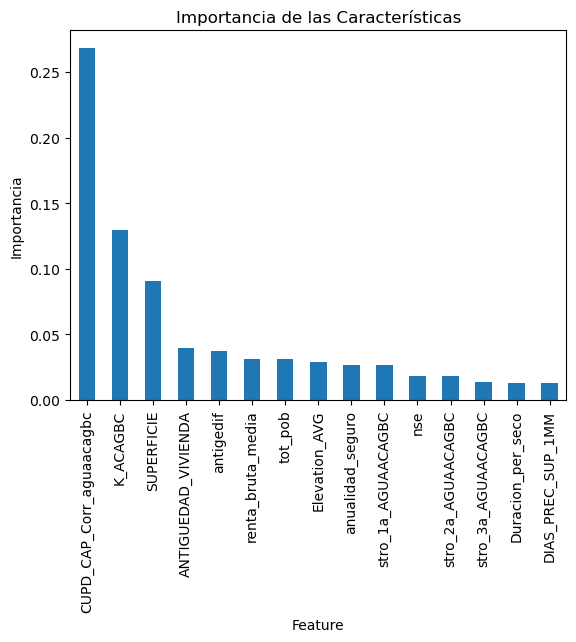

In [19]:
# Gráfico de la importancia de las características
plt.figure(figsize=(12, 6))
importance_df.head(15).plot(kind='bar', x='Feature', y='Importance', legend=False, title='Importancia de las Características')
plt.ylabel('Importancia')
plt.show()

In [20]:
# Se seleccionan las 15 variables más importantes
top_features = importance_df['Feature'].head(15)
X_selected = X[top_features]
X_selected

,CUPD_CAP_Corr_aguaacagbc,K_ACAGBC,SUPERFICIE,ANTIGUEDAD_VIVIENDA,antigedif,renta_bruta_media,tot_pob,Elevation_AVG,anualidad_seguro,stro_1a_AGUAACAGBC,nse,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,Duracion_per_seco,DIAS_PREC_SUP_1MM
2,0.00,50050.00,1020.00,12.00,12.00,13142.61,24363.00,38.13,2.00,1.00,3.86,0.00,0.00,5.96,48.00
3,48.23,41488.54,2700.00,42.00,42.00,16607.79,5414.00,838.62,8.00,1.00,4.02,1.00,2.00,2.70,103.00
4,0.00,70070.00,658.00,58.00,58.00,11359.89,34903.00,9.63,2.00,0.00,3.86,0.00,0.00,3.48,0.00
5,0.00,34402.56,711.00,26.00,26.00,13106.28,28115.00,70.78,3.00,3.00,3.88,3.00,0.00,2.80,69.00
6,0.00,31878.00,500.00,23.00,23.00,13871.24,7898.00,534.26,6.00,0.00,3.40,0.00,0.00,4.33,77.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371384,0.00,74087.98,1980.00,23.00,23.00,14729.22,13672.00,34.52,9.00,1.00,4.89,2.00,2.00,0.92,150.00
371385,0.00,30720.69,480.00,11.00,65.00,12194.31,22341.00,31.03,4.00,0.00,3.80,1.00,0.00,3.07,70.80
371386,201.44,37906.94,936.00,53.00,53.00,11542.29,17162.00,94.13,2.00,3.00,3.39,0.00,0.00,2.84,53.00
371387,2500.00,508039.59,31137.00,18.00,18.00,10270.62,9755.00,89.65,3.00,3.00,3.63,8.00,0.00,3.46,0.00


### 5.2. Verificación de no multicolinealidad 

El Factor de Inflación de la Varianza (VIF, por sus siglas en inglés) es una métrica utilizada para evaluar la multicolinealidad en un modelo lineal. En términos simples, mide cuánto aumenta la varianza de un coeficiente de regresión debido a la correlación con otras variables independientes del modelo.

Interpretación del VIF:
- **Valor exacto de 1:** 
No hay correlación entre una variable independiente y las demás.
No hay multicolinealidad.

- **VIF entre 1 y 5:**
Hay una correlación moderada entre las variables independientes.
Generalmente, este rango no representa un problema grave de multicolinealidad.

- **VIF mayor a 5 (o a veces 10, según algunos autores):**
La multicolinealidad es significativa y podría estar influyendo negativamente en el modelo.
Es recomendable investigar y, posiblemente, eliminar o transformar variables para mitigar el problema.

**Por qué es importante evitar la multicolinealidad:**
Aumenta la varianza de los coeficientes, lo que puede dificultar la interpretación.
Puede generar inestabilidad en el modelo: pequeños cambios en los datos pueden causar grandes variaciones en los coeficientes estimados.

In [21]:
vif_resultados = calcular_vif(X_selected)
vif_resultados

,Variable,VIF
0,const,98.27
1,CUPD_CAP_Corr_aguaacagbc,1.03
2,K_ACAGBC,1.47
3,SUPERFICIE,1.04
4,ANTIGUEDAD_VIVIENDA,1.59
5,antigedif,1.74
6,renta_bruta_media,3.14
7,tot_pob,1.42
8,Elevation_AVG,1.21
9,anualidad_seguro,1.16


Los valores de VIF obtenidos se encuentran en el rango de 1 a 5 para todas las variables, lo que indica que no existe un problema de multicolinealidad en este caso.

### 5.3. Tendencia de variables más importantes

Con fines descriptivos, se realizan gráficas para analizar el comportamiento de algunas variables.

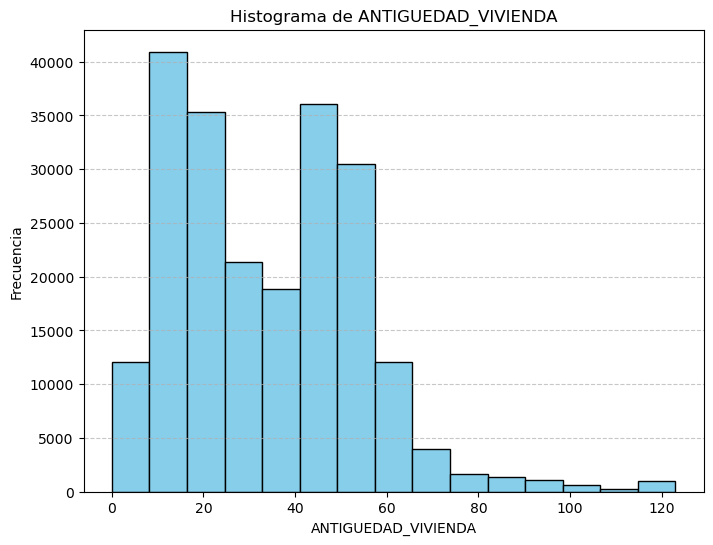

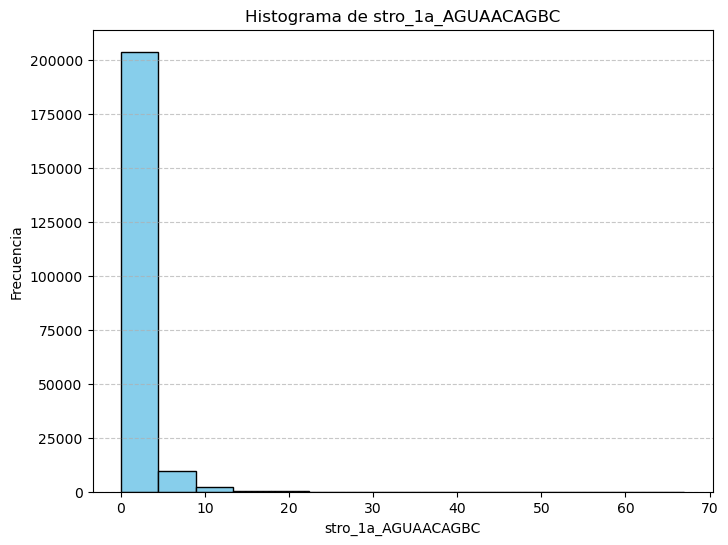

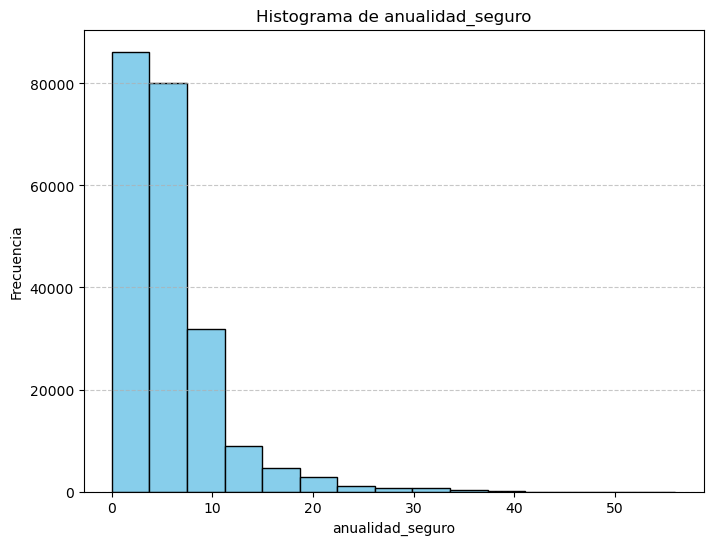

In [22]:
variables = ['ANTIGUEDAD_VIVIENDA', 'stro_1a_AGUAACAGBC', 'anualidad_seguro']

for var in variables:
    graficar_histograma(df_final, var, bins=15, titulo=f'Histograma de {var}', xlabel=var, ylabel='Frecuencia')

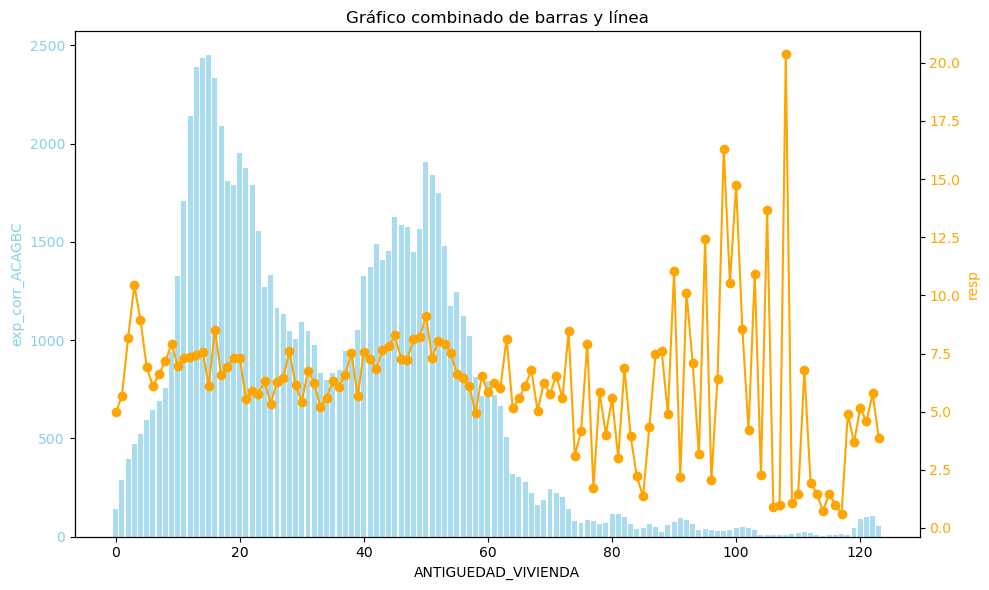

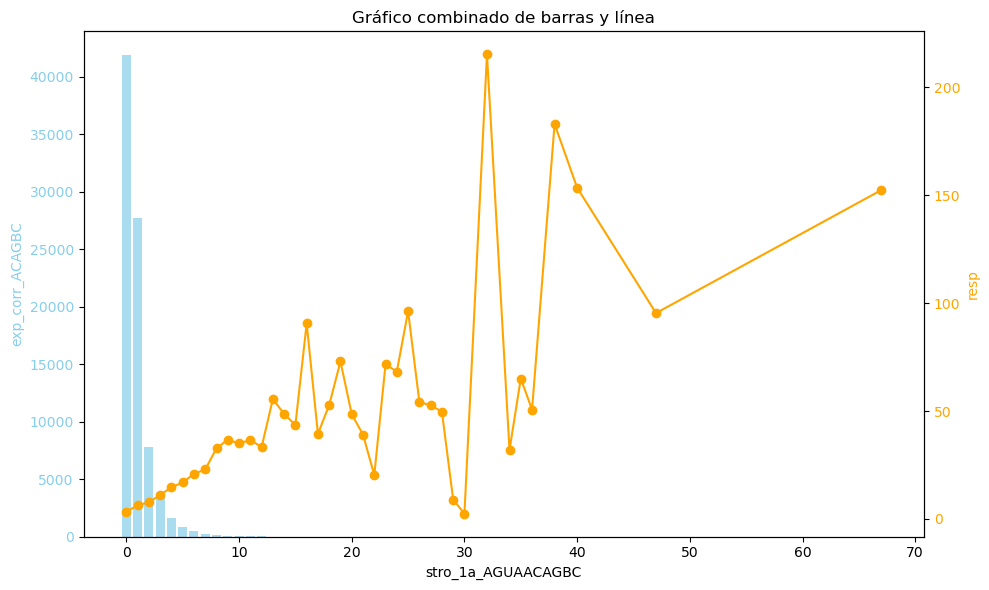

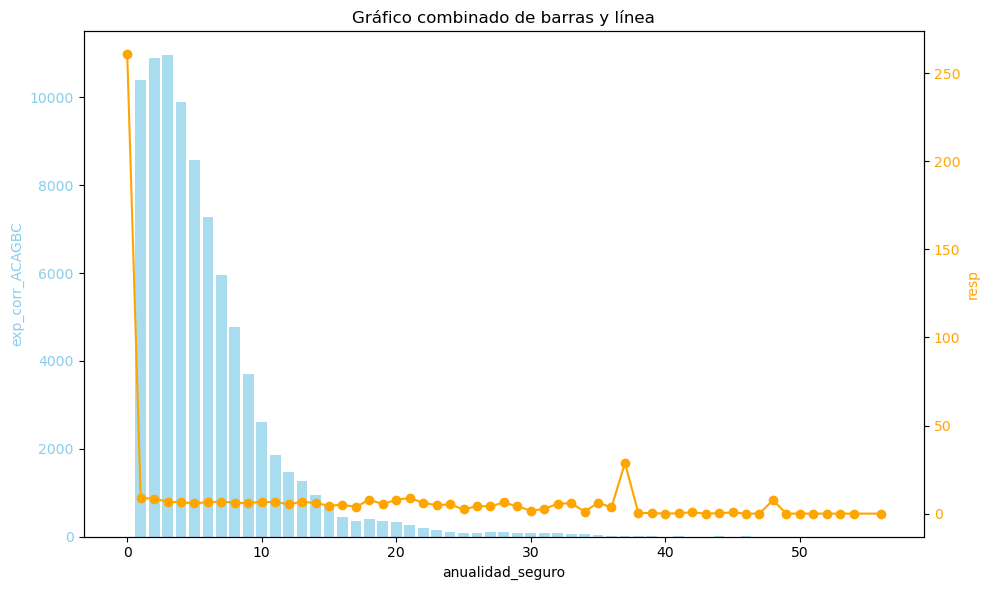

In [23]:
# Gráfico de barras y líneas para algunas variables
variables = ['ANTIGUEDAD_VIVIENDA', 'stro_1a_AGUAACAGBC', 'anualidad_seguro']

for var in variables:
    df_resumido = df_final.groupby(var).agg({'exp_corr_ACAGBC': 'sum', 'resp': 'mean'}).reset_index()
    graficar_barras_linea(df_resumido,var,'exp_corr_ACAGBC','resp')

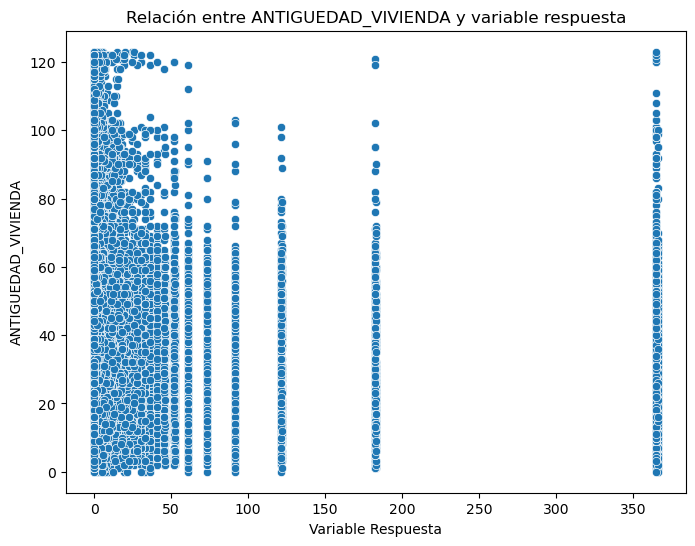

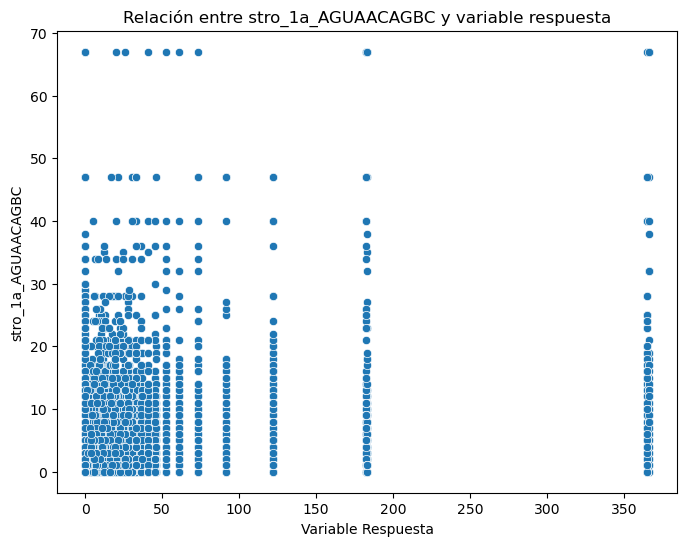

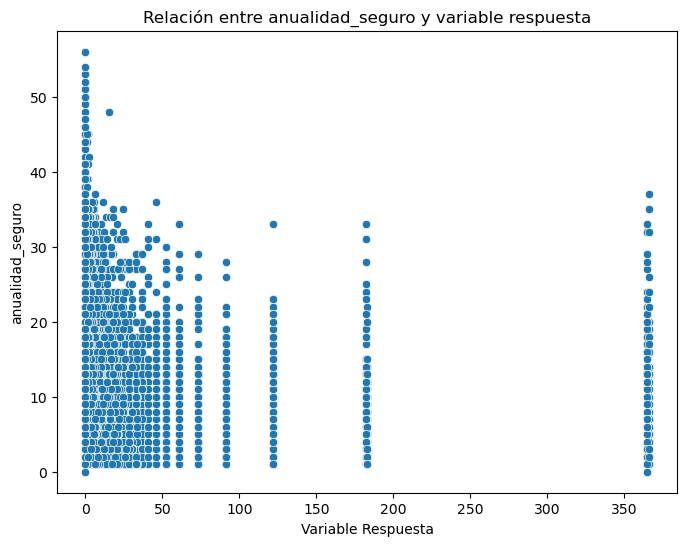

In [24]:
variables = ['ANTIGUEDAD_VIVIENDA', 'stro_1a_AGUAACAGBC', 'anualidad_seguro']
 
for var in variables:
    graficar_dispersion(df_final, x_columna = 'resp', y_columna = var, titulo=f'Relación entre {var} y variable respuesta',
                        xlabel='Variable Respuesta', ylabel=var)

## 6. Modelo Lineal Generalizado (Poisson)

### 6.1. Modelo con TOP 15 variables más importantes

In [25]:
# Prepara los datos
X_selected_const = sm.add_constant(X_selected)
y = df_final['resp']

# Definir la exposición como un offset en logaritmo
offset = np.log(df_final['exp_corr_ACAGBC'])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo = sm.GLM(y, X_selected_const, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar los resultados del modelo
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               216982
Model:                            GLM   Df Residuals:                   216966
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.8406e+06
Date:                Sat, 07 Dec 2024   Deviance:                   1.7459e+07
Time:                        23:38:14   Pearson chi2:                 4.43e+09
No. Iterations:                    18   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [26]:
calculate_bic(resultado)

17681493.016797267

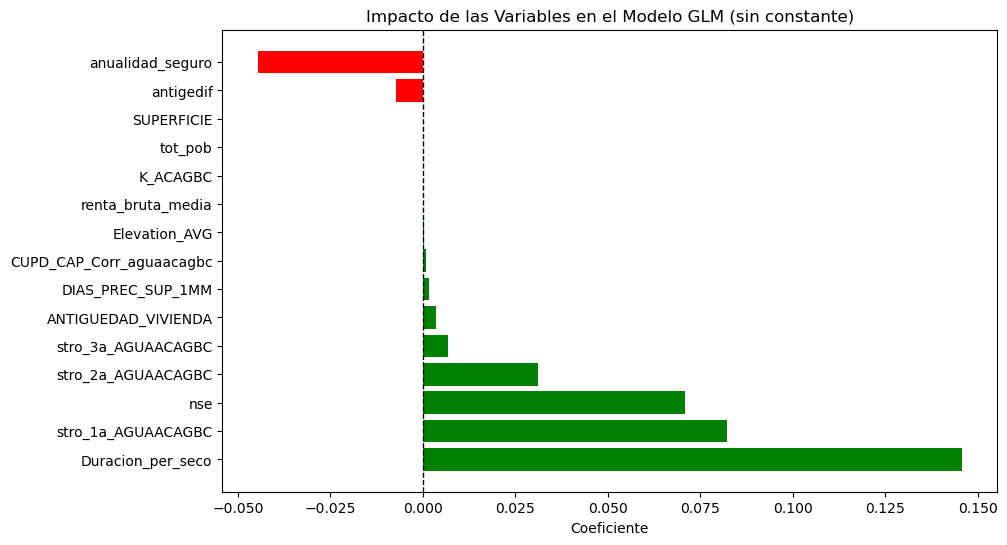

In [27]:
graficar_coeficientes(resultado)

**IMPACTO Y SENTIDO DE NEGOCIO DE CADA VARIABLE** 

**CUPD_CAP_Corr_aguaacagbc (Costo actualizado de reparación de daños de agua):**

- Impacto: Este coeficiente positivo indica que a medida que aumenta el costo de reparación de daños de agua, la frecuencia de siniestros también aumenta. Esto puede reflejar que en áreas con costos de reparación más altos, la probabilidad de que ocurran siniestros es mayor, posiblemente por la presencia de infraestructuras más susceptibles a daños severos o un mantenimiento insuficiente.
- Sentido de negocio: Es crucial para las aseguradoras considerar estos costos al calcular primas y establecer reservas para siniestros.

**K_ACAGBC (Coeficiente de riesgo de agua):**

- Impacto: La relación positiva y fuerte con la variable respuesta implica que a mayor riesgo calculado de agua en una zona, mayor será la frecuencia de siniestros. Esto es consistente con la idea de que una alta exposición al riesgo de agua conlleva un mayor número de eventos.
- Sentido de negocio: Este indicador puede usarse para clasificar las propiedades y determinar el precio del seguro en función del riesgo de agua.

**SUPERFICIE (Superficie construida):**

- Impacto: Un coeficiente positivo sugiere que a mayor superficie de una propiedad, mayor es la frecuencia de siniestros. Las propiedades más grandes pueden tener más puntos vulnerables para los daños por agua.
- Sentido de negocio: Las aseguradoras deben considerar la superficie construida como un factor relevante para calcular primas, dado que propiedades más grandes podrían tener más daños y costos asociados.

**ANTIGUEDAD_VIVIENDA (Antigüedad de la vivienda):**

- Impacto: Un coeficiente positivo indica que la antigüedad de la vivienda incrementa la frecuencia de siniestros. Esto tiene sentido, ya que las viviendas más antiguas tienden a tener sistemas de plomería y materiales que podrían estar más desgastados y ser propensos a daños.
- Sentido de negocio: Las aseguradoras pueden utilizar la antigüedad de la vivienda como un criterio de riesgo para evaluar la probabilidad de siniestros.

**antigedif (Antigüedad del edificio):**

- Impacto: Un coeficiente negativo implica que la antigüedad del edificio tiene un efecto inverso, es decir, los edificios más antiguos pueden tener un menor riesgo de siniestros en comparación con las viviendas más nuevas. Esto puede deberse a un mejor mantenimiento o a una percepción errónea de las condiciones actuales.
- Sentido de negocio: Es importante tener en cuenta la antigüedad del edificio al evaluar el riesgo de siniestros y al momento de ajustar las pólizas de seguro.

**renta_bruta_media (Renta bruta media):**

- Impacto: Un coeficiente positivo sugiere que en zonas con mayores ingresos promedio, la frecuencia de siniestros es mayor. Esto podría estar relacionado con una mayor densidad de propiedades aseguradas o con una mejor capacidad de reporte y manejo de siniestros.
- Sentido de negocio: Podría reflejar un mayor poder adquisitivo de los residentes, que a menudo se correlaciona con una mejor capacidad de reportar y manejar incidentes.

**tot_pob (Total de población):**

- Impacto: El coeficiente positivo indica que en zonas con más habitantes, la frecuencia de siniestros es mayor, lo cual puede atribuirse a una mayor exposición y a la probabilidad de incidentes en áreas más densamente pobladas.
- Sentido de negocio: Las aseguradoras deben considerar la densidad poblacional como un factor para evaluar la frecuencia de siniestros en distintas áreas.

**Elevation_AVG (Altitud promedio):**

- Impacto: Un coeficiente positivo indica que a mayor altitud, mayor es la frecuencia de siniestros, posiblemente por la relación con patrones climáticos específicos como mayor precipitación o eventos climáticos extremos.
- Sentido de negocio: Puede ser importante para las aseguradoras usar la altitud promedio como un criterio de riesgo, especialmente en zonas propensas a lluvias intensas o inundaciones.

**anualidad_seguro (Anualidad del seguro):**

- Impacto: Un coeficiente negativo sugiere que una mayor anualidad de seguro está asociada con una menor frecuencia de siniestros, lo cual podría interpretarse como un reflejo de una mejor cobertura y prevención en propiedades que pagan primas más altas.
- Sentido de negocio: Este factor podría indicar un nivel de cobertura más alto y una gestión de riesgos más eficiente en propiedades aseguradas con primas más altas.

**stro_1a_AGUAACAGBC, stro_2a_AGUAACAGBC, stro_3a_AGUAACAGBC, stro_4a_AGUAACAGBC, stro_5a_AGUAACAGBC (Historial de daños por agua en los primeros años):**

- Impacto: Estos coeficientes positivos indican que los daños en años anteriores tienen una alta correlación con la frecuencia de siniestros actuales, lo cual refuerza la importancia del historial de daños en la evaluación de riesgos.
- Sentido de negocio: La historia de siniestros es un predictor clave para las aseguradoras, ya que un historial de daños elevado implica una mayor probabilidad de que se repitan.

**nse (Nivel socioeconómico del CP):**

- Impacto: Un coeficiente positivo indica que el nivel socioeconómico de la zona influye en la frecuencia de siniestros, probablemente debido a una mayor exposición a la propiedad y un mejor reporte de incidentes.
- Sentido de negocio: Este factor debe ser considerado en las estrategias de segmentación de riesgos para el cálculo de primas.

**Duracion_per_seco (Duración del período seco):**

- Impacto: Un coeficiente positivo sugiere que una mayor duración de períodos secos se asocia con una mayor frecuencia de siniestros, lo que puede indicar un efecto en la integridad de las infraestructuras.
- Sentido de negocio: Las condiciones climáticas prolongadas sin lluvia pueden influir en la exposición de las infraestructuras y en los riesgos de daños por agua.

**DIAS_PREC_SUP_1MM (Días con precipitaciones mayores a 1MM):**

- Impacto: Un coeficiente positivo implica que incluso una cantidad baja de precipitación puede impactar la frecuencia de siniestros.
- Sentido de negocio: Este indicador puede ser útil para modelar riesgos de siniestros relacionados con lluvias moderadas.

**CONCLUSIONES**

1. **Valor de R² y Pseudo R²:** El modelo presenta un Pseudo R² (CS) de 1.000, lo que sugiere un ajuste perfecto a los datos y que explica completamente la variación observada en la variable de respuesta, es decir, la frecuencia de siniestros relacionados con daños por agua. Sin embargo, es importante considerar que el Pseudo R² es específico de modelos de Poisson y no debe interpretarse de la misma manera que el R² de un modelo de regresión lineal tradicional. En modelos de Poisson, un Pseudo R² de 1 puede ser indicativo de sobreajuste o simplemente un reflejo de una relación muy fuerte entre las variables independientes y la dependiente.

2. **Significancia de las variables:** Todas las variables incluidas en el modelo tienen un valor p (P>|z|) de 0.000, lo que significa que son estadísticamente significativas al nivel de confianza del 95%. Esto confirma que cada una de las variables tiene un impacto importante en la predicción de la frecuencia de siniestros relacionados con daños por agua.

3. **Valor del BIC (Bayesian Information Criterion):** El BIC para el modelo es 17681493.0168. Este indicador mide el ajuste del modelo penalizado por el número de variables incluidas, y un BIC más bajo sugiere un modelo mejor ajustado en relación con su complejidad. Comparar este valor con otros modelos candidatos (por ejemplo, modelos con menos variables) permitirá evaluar si la complejidad del modelo mejora realmente su capacidad predictiva. Esta comparación se realizará en la siguiente sección.

4. **Impacto y relevancia de las variables:** Las variables más relevantes, como el costo de reparación, la antigüedad de la vivienda y los históricos de siniestros, tienen un impacto significativo en el análisis de riesgo y la planificación de seguros. Estas variables reflejan patrones relevantes de siniestros y son esenciales para comprender los factores que afectan la frecuencia de los daños por agua.

5. **Implicaciones para la Gestión de Riesgos:** El modelo ofrece un análisis detallado sobre las variables que tienen el mayor impacto en la frecuencia de siniestros por daños de agua en conjuntos residenciales. Esta información puede ser utilizada para diseñar estrategias de prevención de riesgos, ajustes en las pólizas de seguros y programas de mantenimiento enfocados en reducir la frecuencia de siniestros.

6. **Conclusión general:** En resumen, el modelo es robusto y ofrece un análisis detallado de las variables más significativas para predecir la frecuencia de siniestros por daños de agua. Esto proporciona información clave para la gestión de riesgos en el sector de seguros y para la toma de decisiones en estrategias de prevención y planificación.

### 6.2. Modelo con TOP 8 variables más importantes Lasso

In [28]:
# Ajustar modelo Lasso con un parámetro de regularización alpha 
lasso = Lasso(alpha=0.1)  
lasso.fit(X_selected, y)

# Obtener los coeficientes del modelo Lasso
coef = pd.Series(lasso.coef_, index=X_selected.columns)

# Imprimir los coeficientes de todas las variables
print("Coeficientes de Lasso:")
print(coef)

# Seleccionar las 8 variables más importantes (las que tienen mayor valor absoluto de coeficiente)
top_variables = coef.abs().sort_values(ascending=False).head(8).index

# Imprimir las 8 variables más importantes
print("\nTop 8 variables más importantes:")
print(top_variables)

Coeficientes de Lasso:
CUPD_CAP_Corr_aguaacagbc    0.01
K_ACAGBC                    0.00
SUPERFICIE                  0.00
ANTIGUEDAD_VIVIENDA         0.01
antigedif                  -0.01
renta_bruta_media           0.00
tot_pob                     0.00
Elevation_AVG               0.00
anualidad_seguro           -0.10
stro_1a_AGUAACAGBC          1.64
nse                        -0.00
stro_2a_AGUAACAGBC         -0.00
stro_3a_AGUAACAGBC          0.12
Duracion_per_seco           0.42
DIAS_PREC_SUP_1MM           0.00
dtype: float64

Top 8 variables más importantes:
Index(['stro_1a_AGUAACAGBC', 'Duracion_per_seco', 'stro_3a_AGUAACAGBC',
       'anualidad_seguro', 'CUPD_CAP_Corr_aguaacagbc', 'antigedif',
       'ANTIGUEDAD_VIVIENDA', 'Elevation_AVG'],
      dtype='object')


In [29]:
# Crear un nuevo DataFrame con las 8 variables más importantes
X_top_selected = X_selected[top_variables]

# Ahora modelo GLM usando solo las 8 variables más importantes
X_top_selected_const = sm.add_constant(X_top_selected)
modelo_top = sm.GLM(y, X_top_selected_const, family=sm.families.Poisson(), offset=offset)
resultado_top = modelo_top.fit()

# Mostrar los resultados del nuevo modelo
print("\nResumen del modelo GLM con las 8 variables más importantes Lasso:")
print(resultado_top.summary())


Resumen del modelo GLM con las 8 variables más importantes Lasso:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               216982
Model:                            GLM   Df Residuals:                   216973
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.1123e+06
Date:                Sat, 07 Dec 2024   Deviance:                   1.8002e+07
Time:                        23:38:16   Pearson chi2:                 4.63e+09
No. Iterations:                    15   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [30]:
calculate_bic(resultado_top)

18224691.9444498

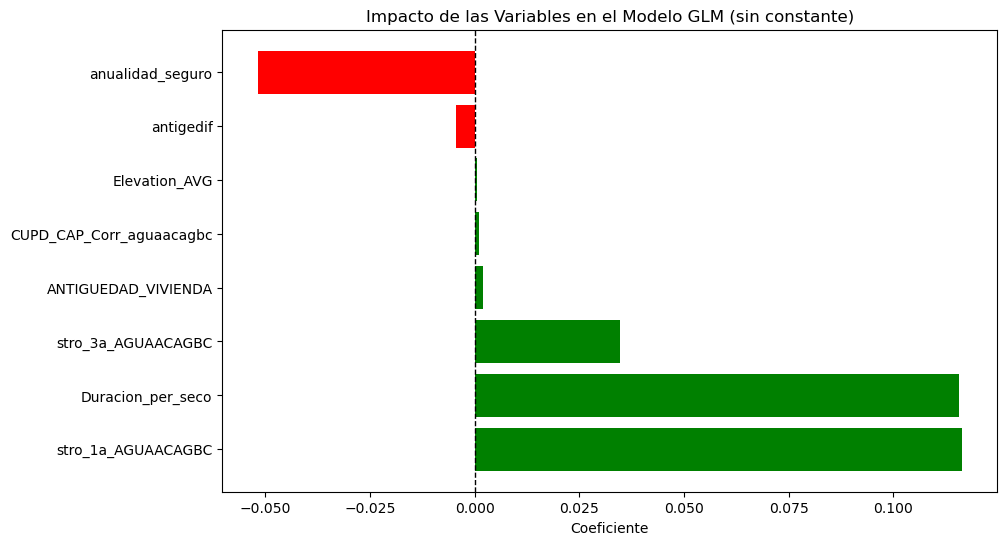

In [31]:
graficar_coeficientes(resultado_top)

**CONCLUSIONES** 

1. **Valor de Pseudo R²:**
El Pseudo R² (CS) es de 0.9998, indicando un ajuste casi perfecto a los datos, similar a la versión anterior, aunque con un modelo reducido. Este valor sugiere que las variables seleccionadas explican la casi totalidad de la variación en la variable dependiente (frecuencia de siniestros por daños de agua).

2. **Significancia de las Variables:**
Todas las variables son estadísticamente significativas (P < 0.05), lo que implica que tienen un impacto relevante en la predicción de la frecuencia de siniestros.

**Variables más relevantes y sus implicaciones:**
- stro_1a_AGUAACAGBC: Esta variable representa un historial de daños por agua en el primer año y muestra un coeficiente positivo significativo (0.1164), indicando que un aumento en los reportes de siniestros previos está asociado con un mayor riesgo de futuros siniestros.
- Duracion_per_seco: Un coeficiente positivo (0.1157) sugiere que un período más largo de condiciones secas incrementa la frecuencia de siniestros, posiblemente debido a un incremento en la vulnerabilidad de las propiedades a daños por agua cuando finalmente hay precipitaciones.
- stro_3a_AGUAACAGBC: El coeficiente (0.0348) refleja la importancia del historial de daños en el tercer año. Aunque más bajo que el de stro_1a, sigue siendo relevante y confirma la tendencia de los daños pasados a influir en los futuros riesgos.
- anualidad_seguro: Tiene un coeficiente negativo (-0.0519), lo que sugiere que una mayor anualidad de seguro está asociada con una menor frecuencia de siniestros. Esto podría indicar una relación de cobertura o ajuste de riesgo que influye en la probabilidad de reporte de siniestros.
- CUPD_CAP_Corr_aguaacagbc: El coeficiente positivo (0.0010) destaca la relevancia del costo actualizado de reparación de daños de agua, un indicador del impacto económico de los siniestros, lo cual refuerza la percepción de que un mayor costo de reparación se asocia con una mayor frecuencia de siniestros.
- antigedif: Esta variable tiene un coeficiente negativo (-0.0045), sugiriendo que las propiedades más antiguas con reformas pueden estar menos propensas a reportar siniestros, tal vez por mejoras estructurales o de infraestructura.
- ANTIGUEDAD_VIVIENDA: Un coeficiente positivo (0.0019) indica que las viviendas más antiguas presentan una mayor frecuencia de siniestros, probablemente por la degradación de sus sistemas a lo largo del tiempo.
- Elevation_AVG: Esta variable también muestra un coeficiente positivo (0.0004), implicando que las propiedades en elevaciones más altas pueden tener una frecuencia mayor de siniestros, posiblemente por factores relacionados con la exposición a condiciones climáticas extremas.

3. **Valor del BIC:**
El BIC del modelo es 18224691.9444, lo que indica un ajuste penalizado que toma en cuenta la complejidad del modelo. Aunque este BIC es mayor que el del modelo anterior (17681493.0168), su valor es todavía competitivo y sugiere que el modelo con las 8 variables más importantes es una versión simplificada que mantiene un buen poder predictivo.

4. **Modelo eficiente y simplificado:** 
La selección de las 8 variables más importantes mediante Lasso ha resultado en un modelo más sencillo y aún así extremadamente eficaz, con un Pseudo R² muy cercano a 1 y un valor de BIC competitivo.

5. **Importancia de la selección de variables:** 
Lasso ha identificado las variables más relevantes que deben ser monitoreadas y gestionadas para prever y mitigar los riesgos de siniestros por daños de agua. Las variables relacionadas con el historial de siniestros y la antigüedad de las propiedades son de particular relevancia.

6. **Aplicación en la industria de seguros:** 
Este modelo puede utilizarse para enfocar esfuerzos en áreas específicas como la evaluación de riesgos y la personalización de pólizas de seguros. También sugiere la importancia de la monitorización de la duración de períodos secos y la elevación de propiedades.

7. **Conclusión general:** 
En conclusión, este modelo simplificado es robusto y proporciona una buena base para tomar decisiones en la gestión de riesgos y en la planificación de estrategias de seguros, manteniendo la mayoría de la capacidad explicativa del modelo más completo.

## 7. Tiempo de ejecución

In [32]:
end_time = time.time()
print(f"Tiempo de ejecución total: {end_time - start_time} segundos")

Tiempo de ejecución total: 49.649532079696655 segundos
